In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from skimage import feature
from skimage.transform import hough_line, hough_line_peaks
from matplotlib import cm

from lsst.eotest.sensor.spotTask import make_ccd_mosaic
from lsst.eotest.sensor import MaskedCCD

from mixcoatl.crosstalk import satellite_mask, crosstalk_fit, crosstalk_model
from mixcoatl.utils import calculate_read_noise

## Calibration

The first step of the crosstalk analysis is to generate the appropriate calibration products. Because we are calculating the electronic crosstalk from a ratio of aggressor and victim amplifiers in units of ADU, we only consider the use of a bias image to calibrate the crosstalk images. 

Below is an example superbias image, formed from a coadded stack of greater than 50 bias images taken during a single image acquisition run.

NOTE: A calibration step that is not shown is the "overscan correction", or removal of the electronic offset through measurement of the serial overscan pixel signals. This is done using `eotest` stack tools that remove this electronic offset row-by-row. The overscan correction is performed on both the superbias image and on any crosstalk images.

Text(0.5, 1.0, 'CCD Superbias Image')

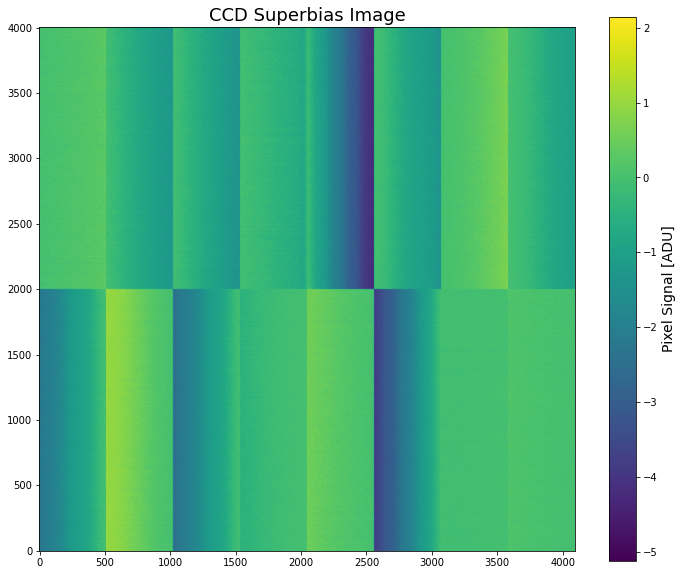

In [2]:
bias_frame = './data/Davis_superbias.fits'

sbias_imarr = make_ccd_mosaic(bias_frame).getArray()

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
im = ax.imshow(sbias_imarr, origin='lower')
cbar = fig.colorbar(im)
cbar.set_label('Pixel Signal [ADU]', fontsize=14)
ax.set_title('CCD Superbias Image', fontsize=18)

## Example Crosstalk Image

Below is an example image of a fake satellite streak projected onto the test CCD that has been calibrated using the previously described overscan correction and subtraction of the superbias image. The segment boundaries have been plotted over the image in white.

The streak passes diagonally across the bottom 8 CCD segments; this allows for the measurement of the crosstalk between all aggressor/victim amplifier pairs on the bottom half of the CCD.

(4004, 4096)


Text(0.5, 1.0, 'CCD Image')

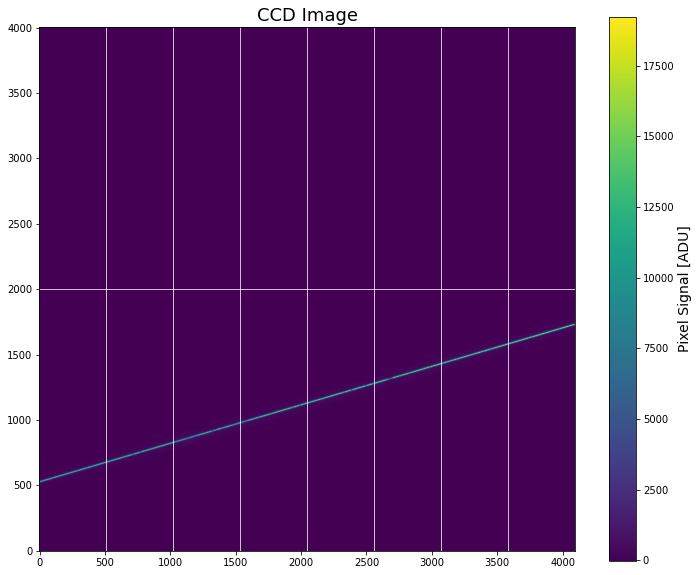

In [3]:
example_image = './data/Davis_example_image.fits'

imarr = make_ccd_mosaic(example_image, bias_frame=bias_frame).getArray()
print(imarr.shape)

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
im = ax.imshow(imarr, origin='lower')

## Overplot segment boundaries
ax.axhline(y=2002, color='white', linewidth=0.75)
for i in range(7):
    ax.axvline(x=512*(i+1), color='white', linewidth=0.75)

cbar = fig.colorbar(im)
cbar.set_label('Pixel Signal [ADU]', fontsize=14)
ax.set_title('CCD Image', fontsize=18)

## Crosstalk Measurement Methodology

### Identify Satellite Streak Location

In order to detect the location of the satellite streak in each amplifier, we use a Hough transform to detect lines in the image.  First a Canny edge detection algorithm is applied to the image to identify the edges of each side of the satellite streak. Next, a Hough transform is performed to measure the properties of the two lines that define either side of the satellite streak.  Finally, by taking the average of the two lines, one can obtain the position of the satellite streak as a line defined by an angle and distance from the origin (Hesse normal form).

The left subplot shows the results of the Canny Edge Detection, the center plot shows the Hough transform of the Canny Edges, and the right plot shows the original CCD segment image with the detected satellite streak overplotted in red.

Text(0.5, 1.0, 'Detected Satellite')

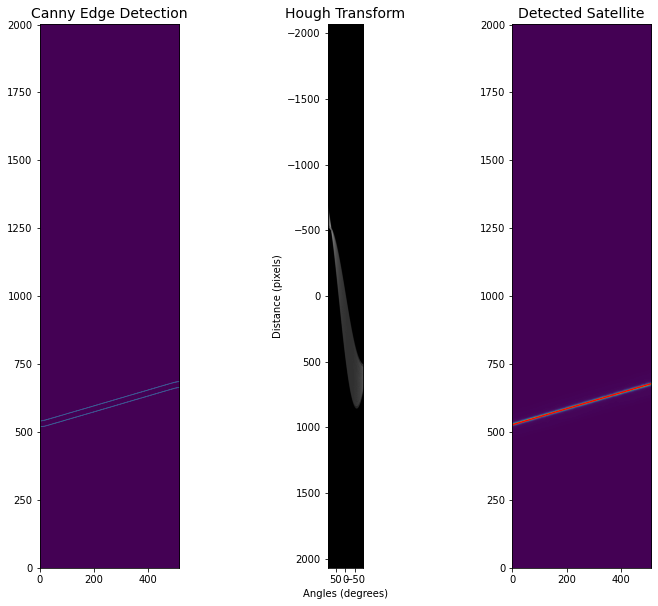

In [4]:
ccd = MaskedCCD(example_image, bias_frame=bias_frame)

agg = 1
vic = 2

aggressor_imarr = ccd.unbiased_and_trimmed_image(agg).getImage().getArray()


tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 1000)
edges = feature.canny(aggressor_imarr, sigma=10, low_threshold=1, high_threshold=25)
h, theta, d = hough_line(edges, theta=tested_angles)
_, angle, dist = hough_line_peaks(h, theta, d)

mean_angle = np.mean(angle)
mean_dist = np.mean(dist)

fig, ax = plt.subplots(1, 3, figsize=(12, 10))
ax[0].imshow(edges, origin='lower')
ax[0].set_title('Canny Edge Detection', fontsize=14)

ax[1].imshow(np.log(1 + h),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
             cmap=cm.gray, aspect=1/1.5)
ax[1].set_title('Hough Transform', fontsize=14)
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')

ax[2].imshow(aggressor_imarr, origin='lower')

origin = np.array((0, aggressor_imarr.shape[1]-1))
y0, y1 = (mean_dist - origin * np.cos(mean_angle)) / np.sin(mean_angle)
ax[2].plot(origin, (y0, y1), '-r')
ax[2].set_title('Detected Satellite', fontsize=14)

### Make Aggressor/Victim Region Masks

Using the satellite streak location, the next step is to create a mask around the satellite streak region on both the aggressor segment image and the victim segment image, shown below. This is done to isolate the regions of the CCD that will be compared in order to calculate the crosstalk coefficient.

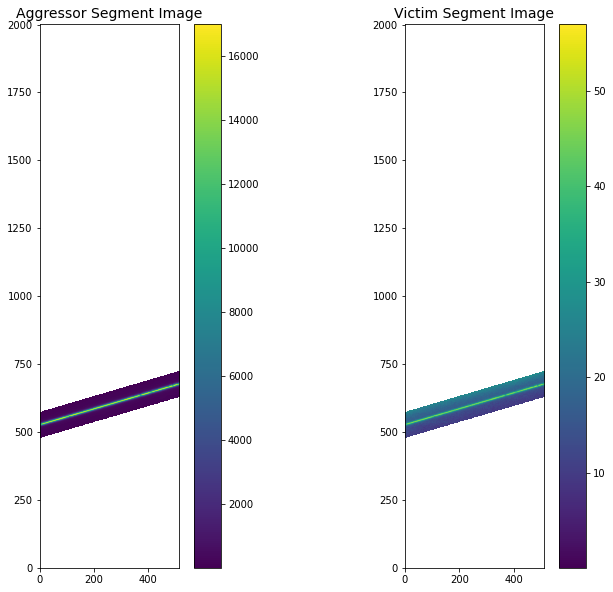

In [5]:
mask = satellite_mask(aggressor_imarr, mean_angle, mean_dist, width=50)
signal = np.max(aggressor_imarr[~mask])
    
victim_imarr = ccd.unbiased_and_trimmed_image(vic).getImage().getArray()
    
fig, ax = plt.subplots(1, 2, figsize=(12, 10))
im0 = ax[0].imshow(np.ma.MaskedArray(aggressor_imarr, mask=mask), origin='lower')
im1 = ax[1].imshow(np.ma.MaskedArray(victim_imarr, mask=mask), origin='lower')
ax[0].set_title('Aggressor Segment Image', fontsize=14)
cbar0 = fig.colorbar(im0, ax=ax[0])
ax[1].set_title('Victim Segment Image', fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax[1])


### Least Squares Minimization of Crosstalk Victim Model

The simplest method to calculate the crosstalk is to simply take a ratio of the induced signal in the victim amplifier compared to the true signal in the aggressor amplifier. However, because of the presence of a scattered light background it is necessary to account for this additional signal when calculating the electronic crosstalk. Therefore the method used to calculate the crosstalk is to assume that the victim segment image is the aggressor segment image scaled by the crosstalk coefficient, plus a sloped plane scattered light background. Using this model, a least squares minimization can be performed, solving jointly for the electronic crosstalk and a scattered light background in order to get a crosstalk coefficient result. 

This is demonstrated below with an image of the aggressor region on the left, the victim region in the center, and the best fit model determined from the least squares minimization on the right.

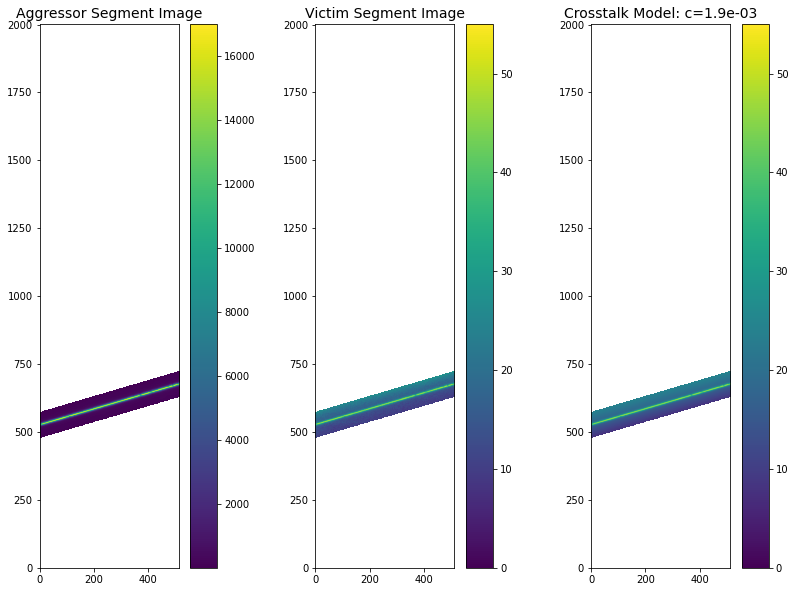

In [6]:
read_noise = calculate_read_noise(ccd, vic)*np.sqrt(2.)
res = crosstalk_fit(aggressor_imarr, victim_imarr, mask, noise=read_noise)

model = crosstalk_model(res[:4], aggressor_imarr)


fig, ax = plt.subplots(1, 3, figsize=(14, 10))
im0 = ax[0].imshow(np.ma.MaskedArray(aggressor_imarr, mask=mask), origin='lower')
im1 = ax[1].imshow(np.ma.MaskedArray(victim_imarr, mask=mask), origin='lower', vmin=0, vmax=55)
im2 = ax[2].imshow(np.ma.MaskedArray(model, mask=mask), origin='lower', vmin=0, vmax=55)
ax[0].set_title('Aggressor Segment Image', fontsize=14)
cbar0 = fig.colorbar(im0, ax=ax[0])
ax[1].set_title('Victim Segment Image', fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax[1])
ax[2].set_title('Crosstalk Model: c={0:.1e}'.format(res[0]), fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax[2])